In [6]:
%load_ext autoreload
import json
import sys
import pathlib
from matplotlib import pylab as plt
import numpy as np
import pandas as pd
import os
import sys
import seaborn as sns
import random
from llm import send_prompt, sort_function
from sort import quicksort, heapsort

cp_data: dict[str, dict] = {}
for file in pathlib.Path('data/shared-dataset/corona_pandemie').rglob('*.ipynb'):
    with open(file) as f:
        cp_data[file.stem.removeprefix('corona_pandemie_')] = json.load(f)

cw_data: dict[str, dict] = {}
for file in pathlib.Path('data/shared-dataset/corona_warn_app_analyse').rglob('*.ipynb'):
    with open(file) as f:
        cw_data[file.stem.removeprefix('corona_warn_app_analyse_')] = json.load(f)

rp_data: dict[str, dict] = {}
for file in pathlib.Path('data/shared-dataset/reproduktionszahl').rglob('*.ipynb'):
    with open(file) as f:
        rp_data[file.stem.removeprefix('reproduktionszahl_')] = json.load(f)

wr_data: dict[str, dict] = {}
for file in pathlib.Path('data/shared-dataset/werbeindustrie').rglob('*.ipynb'):
    with open(file) as f:
        wr_data[file.stem.removeprefix('werbeindustrie_')] = json.load(f)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from copy import deepcopy

def filter_images(data):
    """Sets the image data to None in the output of code cells."""
    for k, v in data.items():
        for cell in v['cells']:
            if cell['cell_type'] == 'code' and 'outputs' in cell:
                for output in cell['outputs']:
                    if 'data' in output and 'image/png' in output['data']:
                        # remove image from data
                        output['data']['image/png'] = None

filter_images(cp_data)
filter_images(cw_data)
filter_images(rp_data)
filter_images(wr_data)

def filter_output_cells(data_array):
    """Removes the output of code cells."""
    data = deepcopy(data_array)
    for k, v in data.items():
        for i, cell in enumerate(v['cells']):
            if cell['cell_type'] == 'code' and 'outputs' in cell:
                #print(cell['outputs'])
                data[k]['cells'][i]['outputs'] = []
    return data

## Token Estimations

In [4]:
from transformers import AutoTokenizer
import os
from dotenv import load_dotenv

load_dotenv()
HUGGINGFACE = os.getenv("HUGGINGFACE")

def calc_tokens(text: str, max_length: int = 0) -> int:
    tokenizer = AutoTokenizer.from_pretrained(
        #"deepseek-ai/DeepSeek-R1",
        "meta-llama/Llama-3.3-70B-Instruct",
        token=HUGGINGFACE)

    tokens = []
    if max_length != 0 and len(text) > max_length:
        for t in [text[i:i + max_length] for i in range(0, len(text), max_length)]:
            tokens.extend(tokenizer.encode(t, add_special_tokens=False))
    else:
        tokens.extend(tokenizer.encode(text, add_special_tokens=False))  # add_special_tokens=True, falls du Sondertokens (z.B. BOS/EOS) berücksichtigen möchtest

    return len(tokens)

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [5]:
tokens = {}

for k, v in cp_data.items():
    tokens[f"cp_{k}"] = calc_tokens(str(v))

for k, v in cw_data.items():
    tokens[f"cw_{k}"] = calc_tokens(str(v))

for k, v in rp_data.items():
    tokens[f"rp_{k}"] = calc_tokens(str(v))

for k, v in wr_data.items():
    tokens[f"wr_{k}"] = calc_tokens(str(v))

print(f"Avg. token per notebook: {sum(tokens.values()) / len(tokens)}")

print(f"Avg. token / notebook (cp): {sum([v for k, v in tokens.items() if k.startswith('cp')]) / len([v for k, v in tokens.items() if k.startswith('cp')])}")
print(f"Avg. token / notebook (cw): {sum([v for k, v in tokens.items() if k.startswith('cw')]) / len([v for k, v in tokens.items() if k.startswith('cw')])}")
print(f"Avg. token / notebook (rp): {sum([v for k, v in tokens.items() if k.startswith('rp')]) / len([v for k, v in tokens.items() if k.startswith('rp')])}")
print(f"Avg. token / notebook (wr): {sum([v for k, v in tokens.items() if k.startswith('wr')]) / len([v for k, v in tokens.items() if k.startswith('wr')])}")

Avg. token per notebook: 4378.15
Avg. token / notebook (cp): 8613.085714285715
Avg. token / notebook (cw): 3982.2
Avg. token / notebook (rp): 3941.1714285714284
Avg. token / notebook (wr): 976.1428571428571


## Reproduktionszahlen

In [6]:
def sort_f1(d1, d2):
    systemprompt = """You are given two Jupyter notebooks (Notebook A and Notebook B), each containing exercises and solutions. Determine which notebook contains the better solutions. A good solution should be correct, accurate and complete. Which notebook is the better one? Output ONLY "Notebook A" or "Notebook B"."""

    return sort_function(d1, d2, rp_data, systemprompt)

sort_f1('4c41', 'fb4b')

4c41 > fb4b


False

In [118]:
cp_data.keys()

dict_keys(['066e', '146f', '1953', '21de', '2281', '23a6', '3669', '44bd', '4c2a', '4c41', '4ca2', '63e1', '6b4e', '6c5b', '6f62', '7cc7', '88a6', '8ac3', '8c43', '8d45', '8eaf', '9eb2', 'a044', 'abd2', 'ad47', 'b14b', 'b56b', 'baa4', 'c926', 'c938', 'cb76', 'd28c', 'eac9', 'fb4b', 'fe28'])

In [8]:
%autoreload 2
from sort import quicksort, heapsort
import random

check_idxs = list(rp_data.keys())
random.shuffle(check_idxs)

rp_data_sorted = heapsort(check_idxs, sort_f1)

146f > 4ca2
146f < 8eaf
2281 < 4c41
4c41 > eac9
23a6 > c926
23a6 > 6f62
c938 > 63e1
c938 > 066e
7cc7 > abd2
7cc7 > 8ac3
21de < 6b4e
6b4e > 8c43
1953 > fb4b
1953 < 88a6
cb76 < fe28
fe28 > 4c2a
8d45 > b14b
8d45 > 3669
4c41 > 8eaf
2281 < eac9
eac9 > baa4
c938 > 23a6
066e < 63e1
63e1 < d28c
c938 < d28c
6b4e > 7cc7
21de < 8c43
8c43 > 44bd
fe28 > 88a6
cb76 > 4c2a
Rate limit hit. Retrying in 4 seconds... (Attempt 1/10)
cb76 > b56b
4c41 > 8d45
eac9 > 8eaf
2281 > baa4
2281 > 9eb2
6b4e < d28c
c938 > 23a6
066e < 63e1
63e1 > ad47
4c41 > fe28
eac9 > 8d45
2281 > 8eaf
9eb2 < baa4
baa4 > a044
4c41 > d28c
eac9 > fe28
2281 > 8d45
baa4 > 8eaf
9eb2 < a044
a044 > 6c5b
eac9 > d28c
2281 < fe28
cb76 > 88a6
b56b < 4c2a
4c2a > 4ca2
fe28 > d28c
2281 > cb76
baa4 < 8d45
3669 > b14b
3669 > 146f
Rate limit hit. Retrying in 10 seconds... (Attempt 1/10)
2281 < d28c
6b4e > c938
8c43 < 7cc7
8ac3 < abd2
abd2 > 6c5b
2281 > 6b4e
8d45 > cb76
baa4 < 3669
146f < b14b
b14b > 9eb2
8d45 > 6b4e
3669 > cb76
baa4 < b14b
146f > 9eb2

In [9]:
rp_data_sorted

['fb4b',
 'b56b',
 '9eb2',
 '4ca2',
 '066e',
 '8ac3',
 'ad47',
 '146f',
 '21de',
 '63e1',
 '1953',
 '4c2a',
 '8eaf',
 '23a6',
 'c938',
 'abd2',
 '44bd',
 '8c43',
 'c926',
 '6f62',
 '6c5b',
 'a044',
 '7cc7',
 'baa4',
 '6b4e',
 '88a6',
 'cb76',
 'b14b',
 '3669',
 '8d45',
 '2281',
 'd28c',
 'fe28',
 'eac9',
 '4c41']

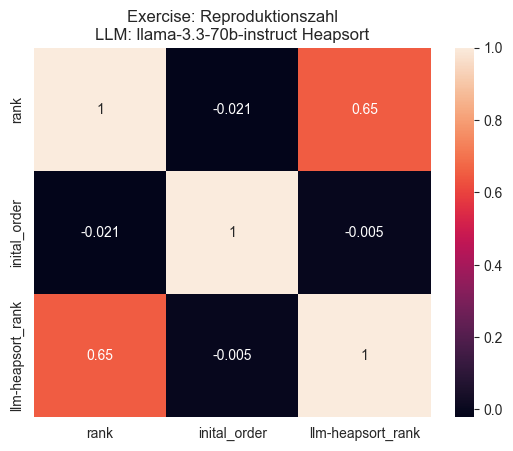

In [17]:
reproduktionszahl_points = pd.read_csv('data/shared-dataset/reproduktionszahl_points.csv')

df = reproduktionszahl_points.loc[:, ['id', 'rank']]

df['inital_order'] = df['id'].map(lambda x: check_idxs.index(x))
df['llm-heapsort_rank'] = df['id'].map(lambda x: rp_data_sorted[::-1].index(x))
df.set_index('id', inplace=True)

plt.title("Exercise: Reproduktionszahl\nLLM: llama-3.3-70b-instruct Heapsort")
sns.heatmap(df.corr(method='kendall'), annot=True)
plt.show()

In [27]:
rp_data_filtered = filter_output_cells(rp_data)

In [28]:
%autoreload 2
from llm import send_prompt, sort_function

def sort_f2(d1, d2):
    systemprompt = """You are given two Jupyter notebooks (Notebook A and Notebook B), each containing exercises and solutions. Determine which notebook contains the better solutions. A good solution should be correct, accurate and complete. Which notebook is the better one? Output ONLY "Notebook A" or "Notebook B"."""

    return sort_function(d1, d2, rp_data_filtered, systemprompt)

In [29]:
initial_ordering = list(rp_data_filtered.keys())
random.shuffle(initial_ordering)

rp_data_filtered_sorted = heapsort(initial_ordering, sort_f2)

44bd > 1953
44bd > 6c5b
a044 < 7cc7
7cc7 < 4c41
8eaf > 9eb2
8eaf < 6b4e
b14b < eac9
eac9 > 23a6
fe28 > 8d45
fe28 > 146f
21de < 2281
2281 > baa4
ad47 < 4c2a
4c2a > b56b
4ca2 > fb4b
4ca2 > 066e
88a6 < 3669
3669 > abd2
4c41 > 44bd
a044 < 7cc7
7cc7 > 6f62
eac9 > 6b4e
b14b > 23a6
b14b < d28c
eac9 > d28c
2281 < fe28
146f < 8d45
8d45 > c926
4ca2 < 4c2a
ad47 > b56b
Rate limit hit. Retrying in 18 seconds... (Attempt 1/10)
ad47 < 8c43
4c2a < 8c43
4c41 > 3669
7cc7 < 44bd
6c5b < 1953
1953 < cb76
44bd < cb76
4c41 > cb76
fe28 > eac9
2281 < 8d45
146f < c926
c926 > c938
4c41 > 8c43
cb76 < 3669
88a6 > abd2
88a6 > 8ac3
4c41 > fe28
3669 > 8c43
cb76 > 88a6
7cc7 < 44bd
6c5b < 1953
1953 > 63e1
3669 > fe28
cb76 > 8c43
44bd < 88a6
8ac3 < abd2
abd2 > 63e1
cb76 < fe28
8d45 < eac9
d28c > 6b4e
Rate limit hit. Retrying in 33 seconds... (Attempt 1/10)
b14b > 23a6
b14b > 6c5b
cb76 < eac9
8d45 < d28c
b14b > 6b4e
6c5b < 23a6
23a6 > 6f62
cb76 > d28c
88a6 > 8c43
44bd > abd2
7cc7 > 1953
7cc7 > a044
88a6 < d28c
8d45 > b14

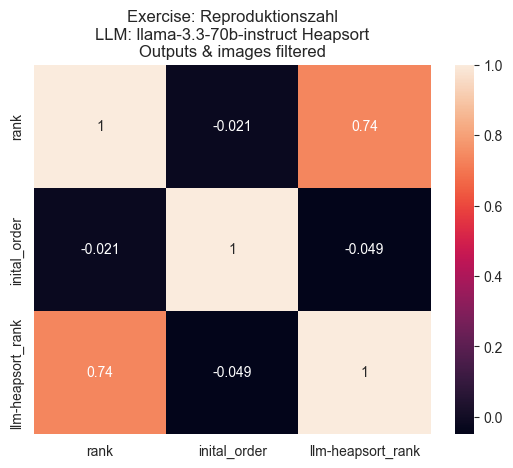

In [30]:
df = reproduktionszahl_points.loc[:, ['id', 'rank']]

df['inital_order'] = df['id'].map(lambda x: check_idxs.index(x))
df['llm-heapsort_rank'] = df['id'].map(lambda x: rp_data_filtered_sorted[::-1].index(x))
df.set_index('id', inplace=True)

plt.title("Exercise: Reproduktionszahl\nLLM: llama-3.3-70b-instruct Heapsort\nOutputs & images filtered")
sns.heatmap(df.corr(method='kendall'), annot=True)
plt.show()

In [40]:
# convert jupyter notebook to markdown
import nbformat
from nbconvert import MarkdownExporter

def nb_to_md(nb):
    exporter = MarkdownExporter()
    markdown, _ = exporter.from_notebook_node(nbformat.from_dict(nb))
    return markdown

nb_to_md(nbformat.read('data/shared-dataset/corona_pandemie/corona_pandemie_4c41.ipynb', as_version=4))

'### Aufgabe: Corona-Pandemie\n\n\nIm Frühjahr 2020 begann sich das neuartiges Coronavirus SARS-CoV-2, welches die Lungenerkrankung Covid-19 verursachen kann, in Deutschland und Europa schlagartig zu verbreiten. In dieser Aufgabe analysieren und visualisieren Sie das Infektionsgeschehen in Deutschland.\n\n**Ihre Daten**\n\nEin vereinfachter Datensatz des Robert Koch Instituts (RKI) steht Ihnen in dieser Aufgabe zur Verfügung.\n\n**Ihre Aufgaben**\n\n(1) Führen Sie zunächst die unten stehende Code-Zelle aus, um den Datensatz und die Pandas-Bibliothek verfügbar zu machen.\n\n\n\n```python\nimport pandas as pd\n\n# Daten des Robert Koch Instituts\nRKI_data_simplified = \'http://lab.bialonski.de/data/ds/kUdBuPrXjvr5d640Ey3UN82VKz646KLj2tuZFTFZ.csv\'\n```\n\n(2) Importieren Sie mithilfe von Pandas den Datensatz in einen DataFrame, den Sie `df_covid` nennen. Nutzen Sie dazu die Variable `RKI_data_simplified`.\n\n\n\n```python\n# Ihr Code\n\ndf = pd.read_csv(RKI_data_simplified)\ndf.head()\n`

In [41]:
nbformat.read('data/shared-dataset/corona_pandemie/corona_pandemie_4c41.ipynb', as_version=4)

{'cells': [{'cell_type': 'markdown',
   'metadata': {},
   'source': '### Aufgabe: Corona-Pandemie\n\n\nIm Frühjahr 2020 begann sich das neuartiges Coronavirus SARS-CoV-2, welches die Lungenerkrankung Covid-19 verursachen kann, in Deutschland und Europa schlagartig zu verbreiten. In dieser Aufgabe analysieren und visualisieren Sie das Infektionsgeschehen in Deutschland.\n\n**Ihre Daten**\n\nEin vereinfachter Datensatz des Robert Koch Instituts (RKI) steht Ihnen in dieser Aufgabe zur Verfügung.\n\n**Ihre Aufgaben**\n\n(1) Führen Sie zunächst die unten stehende Code-Zelle aus, um den Datensatz und die Pandas-Bibliothek verfügbar zu machen.\n'},
  {'cell_type': 'code',
   'execution_count': 2,
   'metadata': {},
   'outputs': [],
   'source': "import pandas as pd\n\n# Daten des Robert Koch Instituts\nRKI_data_simplified = 'http://lab.bialonski.de/data/ds/kUdBuPrXjvr5d640Ey3UN82VKz646KLj2tuZFTFZ.csv'"},
  {'cell_type': 'markdown',
   'metadata': {},
   'source': '(2) Importieren Sie mithil

In [44]:
rp_data['88a6']

{'cells': [{'cell_type': 'markdown',
   'metadata': {},
   'source': ['### Aufgabe: Reproduktionszahl\n',
    '\n',
    '\n',
    'Sie bestimmen in dieser Aufgabe die Reproduktionszahl $R_0$ für die Covid-19 Pandemie in Deutschland anhand der Daten des Robert-Koch-Instituts. Die Reproduktionszahl $R_0$ gibt an, wie viele Menschen von einer infektiösen Person durchschnittlich angesteckt werden, wenn kein Mitglied der Population gegenüber dem Erreger immun ist.\n',
    '\n',
    'Sie werden eine vereinfachte Schätzung der $R_0$-Zahl durchführen. Die $R_0$-Zahl eines Tages $t$ sei definiert als\n',
    '\n',
    '$$ R_0(t) := \\frac{\\sum_{x = t-3}^t I_x }{\\sum_{x = t-7}^{t-4} I_x},$$\n',
    '\n',
    'wobei $I_x$ die Anzahl der Neuinfizierten eines Tages $x$ bezeichnet.\n',
    '\n',
    'Die $R_0$-Zahl entspricht also der Summe der Infizierten innerhalb eines 4-Tageszeitraums dividiert durch die Summe der Infizierten des davorliegenden 4-Tageszeitraums.\n',
    '\n',
    '**Ihre Daten

## Corona Warn App Analyse

In [6]:
def sort_f3(d1, d2):
    systemprompt = """You are given two Jupyter notebooks (Notebook A and Notebook B), each containing exercises and solutions. Determine which notebook contains the better solutions. A good solution should be correct, accurate and complete. Which notebook is the better one? Output ONLY "Notebook A" or "Notebook B"."""

    return sort_function(d1, d2, cw_data, systemprompt)

sort_f3('4c41', 'fb4b')

check_idxs = list(cw_data.keys())
random.shuffle(check_idxs)

cw_data_sorted = heapsort(check_idxs, sort_f3)

4c41 > fb4b
b14b > eac9
b14b > 4ca2
d28c > 2281
d28c > 8c43
21de > 8d45
21de < 7cc7
88a6 > a044
88a6 > 6f62
3669 > 6b4e
3669 > abd2
fb4b < baa4
baa4 > 23a6
8eaf > cb76
8eaf > 1953
8ac3 < 066e
066e < c938
c926 > b56b
c926 > ad47
d28c > b14b
8c43 < 2281
2281 > 44bd
88a6 > 7cc7
6f62 > a044
6f62 > 9eb2
baa4 > 3669
fb4b < 23a6
23a6 > 6c5b
c938 > 8eaf
8ac3 < 066e
066e > 146f
d28c > c926
2281 > b14b
8c43 < 44bd
44bd > 4c2a
baa4 > 88a6
23a6 > 3669
fb4b < 6c5b
6c5b < 4c41
23a6 > 4c41
d28c > c938
2281 > c926
44bd > b14b
8c43 < 4c2a
4c2a < fe28
44bd > fe28
d28c > baa4
Rate limit hit. Retrying in 20 seconds... (Attempt 1/10)
2281 > c938
44bd > c926
fe28 > b14b
8c43 < 4c2a
4c2a < 63e1
fe28 > 63e1
2281 > baa4
44bd < c938
066e < 8eaf
1953 > cb76
1953 > eac9
c938 > baa4
44bd > 8eaf
fe28 > c926
63e1 > b14b
8c43 < 4c2a
4c2a > 4ca2
44bd > baa4
fe28 > 8eaf
63e1 > c926
4c2a < b14b
b14b > 4ca2
fe28 > baa4
63e1 > 8eaf
b14b > c926
4c2a > 4ca2
4c2a > 8c43
63e1 > baa4
b14b > 8eaf
4c2a < c926
Rate limit hit. Ret

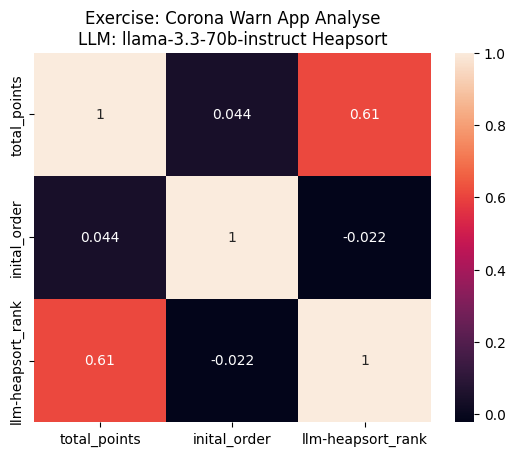

In [15]:
corona_warn_app_analyse_points = pd.read_csv('data/shared-dataset/corona_warn_app_analyse_points.csv')

df = corona_warn_app_analyse_points.loc[:, ['id', 'total_points']]

df['inital_order'] = df['id'].map(lambda x: check_idxs.index(x))
df['llm-heapsort_rank'] = df['id'].map(lambda x: cw_data_sorted[::1].index(x))
df.set_index('id', inplace=True)

plt.title("Exercise: Corona Warn App Analyse\nLLM: llama-3.3-70b-instruct Heapsort")
sns.heatmap(df.corr(method='kendall'), annot=True)
plt.show()

In [18]:
from copy import deepcopy
def filter_output_cells(data_array):
    """Removes the output of code cells."""
    data = deepcopy(data_array)
    for k, v in data.items():
        for i, cell in enumerate(v['cells']):
            if cell['cell_type'] == 'code' and 'outputs' in cell:
                #print(cell['outputs'])
                data[k]['cells'][i]['outputs'] = []
    return data

cw_data_filterd = filter_output_cells(cw_data)

def sort_f4(d1, d2):
    systemprompt = """You are given two Jupyter notebooks (Notebook A and Notebook B), each containing exercises and solutions. Determine which notebook contains the better solutions. A good solution should be correct, accurate and complete. Which notebook is the better one? Output ONLY "Notebook A" or "Notebook B"."""

    return sort_function(d1, d2, cw_data_filterd, systemprompt)

check_idxs = list(cw_data.keys())
random.shuffle(check_idxs)

cw_data_sorted = heapsort(check_idxs, sort_f4)

Rate limit hit. Retrying in 1351 seconds... (Attempt 1/10)
066e > 21de
066e < 8eaf
3669 > 63e1
3669 > 8c43
b14b > 23a6
b14b > 8ac3
b56b > 6c5b
b56b > 4c2a
c926 > baa4
c926 > 4c41
7cc7 > 6f62
7cc7 > abd2
146f < 44bd
44bd > 88a6
1953 > ad47
1953 > 9eb2
6b4e > 4ca2
6b4e < 2281
3669 > 8eaf
8c43 > 63e1
8c43 > a044
b56b < b14b
8ac3 < 23a6
23a6 > cb76
7cc7 > c926
abd2 < 6f62
6f62 > fb4b
1953 > 44bd
9eb2 < ad47
ad47 > 8d45
Rate limit hit. Retrying in 37 seconds... (Attempt 1/10)
3669 < 2281
6b4e > 4ca2
6b4e < c938
2281 > c938
7cc7 > b14b
6f62 < c926
4c41 > baa4
4c41 > d28c
2281 > 1953
3669 > c938
8c43 > 8eaf
a044 < 63e1
63e1 > eac9
2281 > 7cc7
3669 > 1953
8c43 < c938
6b4e > 4ca2
6b4e < fe28
c938 > fe28
3669 < 7cc7
c926 > b14b
6f62 < 4c41
d28c > baa4
d28c > 21de
3669 > c926
c938 > 1953
8c43 < fe28
6b4e > 4ca2
6b4e > 066e
c938 > c926
Rate limit hit. Retrying in 37 seconds... (Attempt 1/10)
fe28 > 1953
8c43 > 6b4e
63e1 > 8eaf
a044 < eac9
63e1 < eac9
8c43 < eac9
fe28 < eac9
c938 > eac9
eac9 > c926

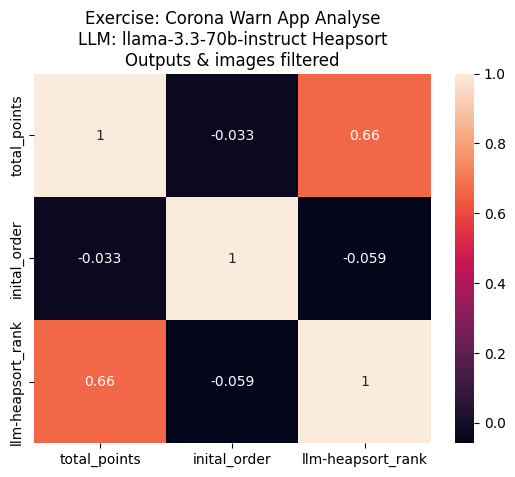

In [58]:
df = corona_warn_app_analyse_points.loc[:, ['id', 'total_points']]

df['inital_order'] = df['id'].map(lambda x: check_idxs.index(x))
df['llm-heapsort_rank'] = df['id'].map(lambda x: cw_data_sorted[::1].index(x))
df.set_index('id', inplace=True)

plt.title("Exercise: Corona Warn App Analyse\nLLM: llama-3.3-70b-instruct Heapsort\nOutputs & images filtered")
sns.heatmap(df.corr(method='kendall'), annot=True)
plt.show()

In [60]:
df.sort_values('llm-heapsort_rank')

,total_points,inital_order,llm-heapsort_rank
id,,,
fb4b,0,5,0
9eb2,0,9,1
146f,0,21,2
6c5b,2,28,3
8ac3,4,14,4
4ca2,10,18,5
8d45,9,4,6
abd2,9,11,7
066e,13,33,8


## Corona Pandemie

In [8]:
cp_data_filterd = filter_output_cells(cp_data)

def sort_f5(d1, d2):
    systemprompt = """You are given two Jupyter notebooks (Notebook A and Notebook B), each containing exercises and solutions. Determine which notebook contains the better solutions. A good solution should be correct, accurate and complete. Which notebook is the better one? Output ONLY "Notebook A" or "Notebook B"."""

    return sort_function(d1, d2, cp_data_filterd, systemprompt)

check_idxs = list(cp_data_filterd.keys())
random.shuffle(check_idxs)

cp_data_sorted = heapsort(check_idxs, sort_f5)

63e1 > 8c43
63e1 > ad47
Request timed out. Retrying in 2 seconds... (Attempt 1/10)
146f < d28c


KeyboardInterrupt: 

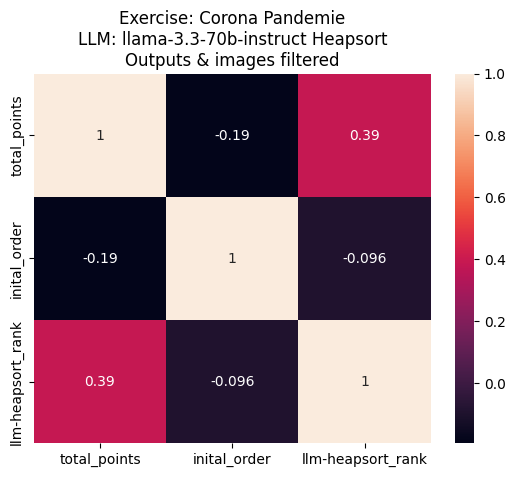

In [62]:
corona_pandemie_points = pd.read_csv('data/shared-dataset/corona_pandemie_points.csv')

df = corona_pandemie_points.loc[:, ['id', 'total_points']]

df['inital_order'] = df['id'].map(lambda x: check_idxs.index(x))
df['llm-heapsort_rank'] = df['id'].map(lambda x: cp_data_sorted[::1].index(x))
df.set_index('id', inplace=True)

plt.title("Exercise: Corona Pandemie\nLLM: llama-3.3-70b-instruct Heapsort\nOutputs & images filtered")
sns.heatmap(df.corr(method='kendall'), annot=True)
plt.show()

In [63]:
df.sort_values('llm-heapsort_rank')

,total_points,inital_order,llm-heapsort_rank
id,,,
8ac3,0,28,0
fb4b,5,35,1
146f,2,29,2
9eb2,11,22,4
066e,29,25,5
21de,25,3,6
6c5b,14,15,7
4c2a,35,20,8
ad47,35,26,9


In [22]:
%autoreload 2
from llm import send_prompt, sort_function
def sort_f6(d1, d2):
    systemprompt = """You are given two Jupyter notebooks (Notebook A and Notebook B), each containing exercises and solutions. Determine which notebook contains the better solutions. A good solution should be correct, accurate and complete. Which notebook is the better one? Output ONLY "Notebook A" or "Notebook B"."""

    return sort_function(d1, d2, cp_data, systemprompt)

check_idxs = list(cp_data.keys())
random.shuffle(check_idxs)

cp_data_sorted = heapsort(check_idxs, sort_f6)

<think>
Okay, I need to determine which notebook, A or B, has the better solutions based on the given criteria: correct, accurate, and complete. Let me go through each notebook step by step.

Starting with Notebook A, I see that in step (3), the user is instructed to convert the 'Meldedatum' column to datetime and set it as the index. The code provided is:

pd.to_datetime(df_covid.loc[:,'Meldedatum'])
pd.DataFrame.set_index(df_covid,'Meldedatum')

Hmm, wait a minute. The first line converts the 'Meldedatum' column to datetime but doesn't assign it back to the DataFrame. So, this line doesn't actually change the DataFrame. The second line uses pd.DataFrame.set_index, which is a static method, but it's not called correctly. It should be df_covid.set_index('Meldedatum'), not pd.DataFrame.set_index(df_covid, 'Meldedatum'). This means the index isn't being set properly, which could cause issues in subsequent steps.

Now looking at Notebook B, in the same step (3), the code is:

df_covid['Me

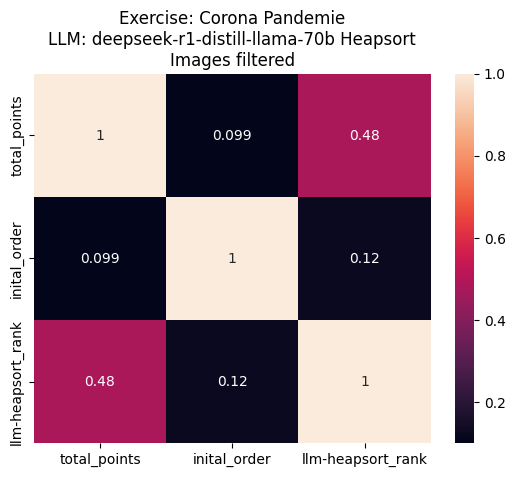

In [26]:
corona_pandemie_points = pd.read_csv('data/shared-dataset/corona_pandemie_points.csv')

df = corona_pandemie_points.loc[:, ['id', 'total_points']]

df['inital_order'] = df['id'].map(lambda x: check_idxs.index(x))
df['llm-heapsort_rank'] = df['id'].map(lambda x: cp_data_sorted[::1].index(x))
df.set_index('id', inplace=True)

plt.title("Exercise: Corona Pandemie\nLLM: deepseek-r1-distill-llama-70b Heapsort\nImages filtered")
sns.heatmap(df.corr(method='kendall'), annot=True)
plt.show()

In [29]:
df.sort_values('llm-heapsort_rank')

,total_points,inital_order,llm-heapsort_rank
id,,,
8ac3,0,1,0
6c5b,14,4,1
9eb2,11,5,2
fb4b,5,25,3
146f,2,33,4
88a6,35,2,5
21de,25,18,6
4ca2,31,20,7
3669,36,26,8
